## predictive model

In [15]:
# import libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size': 14})
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.inspection import permutation_importance

from yellowbrick.classifier import ConfusionMatrix
from sklearn.model_selection import GridSearchCV,  RepeatedStratifiedKFold

In [2]:
df = pd.read_csv("data/customer_booking.csv", encoding="ISO-8859-1")


In [3]:
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


In [4]:
df_final = df

In [5]:
# converting sales channel and trip type into a numerical format
from sklearn.preprocessing import OneHotEncoder


encoder = OneHotEncoder(handle_unknown='ignore')

encoder_df = pd.DataFrame(encoder.fit_transform(df[["sales_channel"]]).toarray())
encoder_df = encoder_df.rename(columns={0:'Internet', 1:'Mobile'})
df_final = df_final.join(encoder_df)

encoder_df = pd.DataFrame(encoder.fit_transform(df[["trip_type"]]).toarray())
encoder_df = encoder_df.rename(columns={0:'RoundTRip', 1:'OneWayTrip',2:'CircleTrip'})
df_final = df_final.join(encoder_df)

In [6]:
# dropping the sales channel and trip type cols
df_final.drop(['sales_channel', 'trip_type','booking_origin', 'route'], axis=1, inplace = True)

In [7]:
label = df['booking_complete']

In [8]:
df_final = df_final.drop('booking_complete', axis=1)

In [9]:
df_final

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,Internet,Mobile,RoundTRip,OneWayTrip,CircleTrip
0,2,262,19,7,Sat,1,0,0,5.52,1.0,0.0,0.0,0.0,1.0
1,1,112,20,3,Sat,0,0,0,5.52,1.0,0.0,0.0,0.0,1.0
2,2,243,22,17,Wed,1,1,0,5.52,1.0,0.0,0.0,0.0,1.0
3,1,96,31,4,Sat,0,0,1,5.52,1.0,0.0,0.0,0.0,1.0
4,2,68,22,15,Wed,1,0,1,5.52,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2,27,6,9,Sat,1,0,1,5.62,1.0,0.0,0.0,0.0,1.0
49996,1,111,6,4,Sun,0,0,0,5.62,1.0,0.0,0.0,0.0,1.0
49997,1,24,6,22,Sat,0,0,1,5.62,1.0,0.0,0.0,0.0,1.0
49998,1,15,6,11,Mon,1,0,1,5.62,1.0,0.0,0.0,0.0,1.0


In [10]:
# preparing numerical data for machine learning
df_numerical = df_final.select_dtypes(include=['int64', 'float64'])

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df_numerical)

In [11]:
# convert the scaled numerical data
df_numerical = df_final.select_dtypes(include=['int64', 'float64'])
scaled_df = pd.DataFrame(scaled_df, columns=df_numerical.columns)


In [12]:
scaled_df['label']  = label

In [13]:
scaled_df

,num_passengers,purchase_lead,length_of_stay,flight_hour,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,Internet,Mobile,RoundTRip,OneWayTrip,CircleTrip,label
0,0.400684,1.957530,-0.119353,-0.381764,0.703747,-0.649919,-0.863497,-1.174175,0.355785,-0.355785,-0.048222,-0.08832,0.100808,0
1,-0.579559,0.299164,-0.089844,-1.120780,-1.420965,-0.649919,-0.863497,-1.174175,0.355785,-0.355785,-0.048222,-0.08832,0.100808,0
2,0.400684,1.747470,-0.030824,1.465775,0.703747,1.538654,-0.863497,-1.174175,0.355785,-0.355785,-0.048222,-0.08832,0.100808,0
3,-0.579559,0.122272,0.234761,-0.936026,-1.420965,-0.649919,1.158082,-1.174175,0.355785,-0.355785,-0.048222,-0.08832,0.100808,0
4,0.400684,-0.187290,-0.030824,1.096267,0.703747,-0.649919,1.158082,-1.174175,0.355785,-0.355785,-0.048222,-0.08832,0.100808,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.400684,-0.640577,-0.502977,-0.012257,0.703747,-0.649919,1.158082,-1.107368,0.355785,-0.355785,-0.048222,-0.08832,0.100808,0
49996,-0.579559,0.288108,-0.502977,-0.936026,-1.420965,-0.649919,-0.863497,-1.107368,0.355785,-0.355785,-0.048222,-0.08832,0.100808,0
49997,-0.579559,-0.673744,-0.502977,2.389544,-1.420965,-0.649919,1.158082,-1.107368,0.355785,-0.355785,-0.048222,-0.08832,0.100808,0
49998,-0.579559,-0.773246,-0.502977,0.357251,0.703747,-0.649919,1.158082,-1.107368,0.355785,-0.355785,-0.048222,-0.08832,0.100808,0


<Axes: >

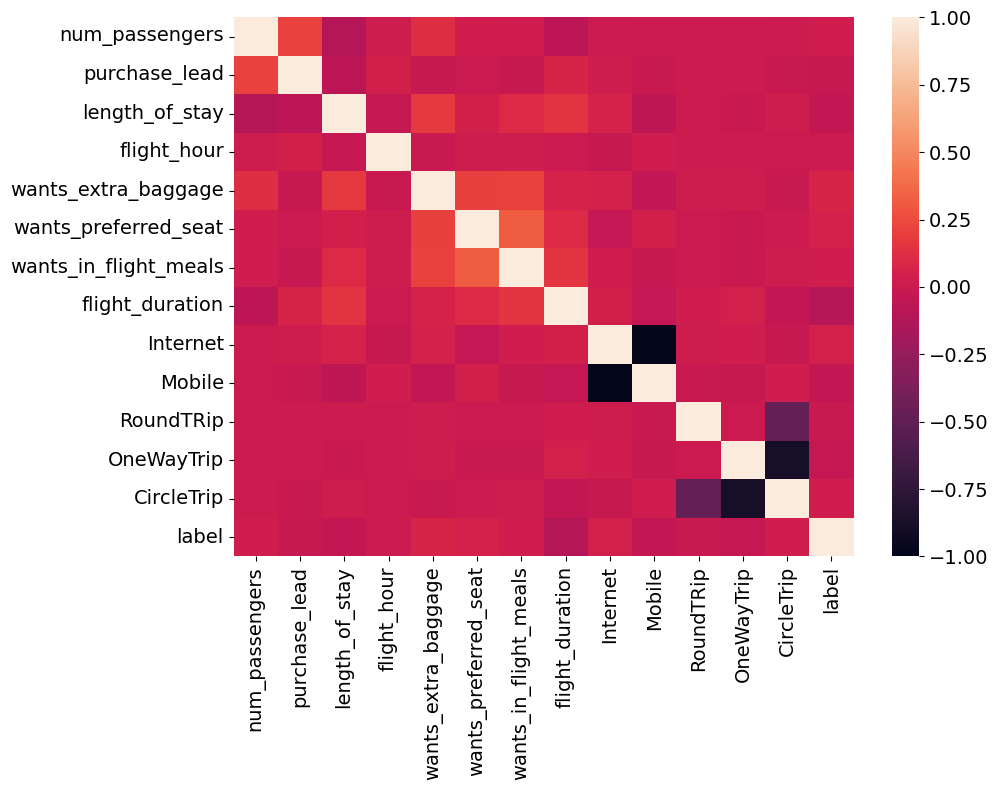

In [14]:
# corr heatmap to visualize the linear relationships between the numerical features in the scaled df 
corr = scaled_df.corr()

plt.figure(figsize=(10,7))

sns.heatmap(corr)

In [53]:
# splits the data into training and testing 
from sklearn.model_selection import train_test_split

X = scaled_df.iloc[:,:-1]
y = scaled_df['label']

X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.20, random_state=42)

In [55]:
# create functions to fit and predict the values of whether customer would complete the booking.
    Also functions with metrics to evaluate the model prediction.
def model_fit_predict(model, X, y, X_predict):
    model.fit(X, y)
    return model.predict(X_predict)

def acc_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

def pre_score(y_true, y_pred):
    return precision_score(y_true, y_pred)

def f_score(y_true, y_pred):
    return f1_score(y_true, y_pred)

In [56]:
# #create an instance of the classifier and fit the training data
clf_rf = RandomForestClassifier(max_depth =50 , min_samples_split=5,random_state=0)

In [57]:
# checking training accuracy
y_pred_train = model_fit_predict(clf_rf, X_train, y_train, X_train)
set(y_pred_train)

f1 = round(f1_score(y_train, y_pred_train),2) 

acc = round(accuracy_score(y_train, y_pred_train),2) 

pre = round(precision_score(y_train, y_pred_train),2) 

print(f"Accuracy, precision and f1-score for training data are {acc}, {pre} and {f1} respectively")

Accuracy, precision and f1-score for training data are 0.93, 1.0 and 0.71 respectively


0.93175

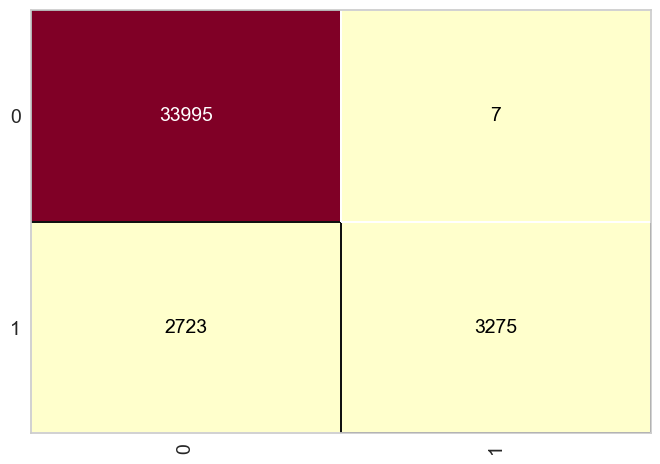

In [58]:
cm = ConfusionMatrix(clf_rf, classes=[0,1])
cm.fit(X_train, y_train)

cm.score(X_train, y_train)

In [59]:
clf_rf = RandomForestClassifier(max_depth =50 , min_samples_split=5,random_state=0)

y_pred_test = model_fit_predict(clf_rf, X_train, y_train, X_test)

f1 = round(f1_score(y_test, y_pred_test),2) 

acc = round(accuracy_score(y_test, y_pred_test),2) 

pre = round(precision_score(y_test, y_pred_test),2) 

print(f"Accuracy, precision and f1-score for training data are {acc}, {pre} and {f1} respectively")

Accuracy, precision and f1-score for training data are 0.85, 0.4 and 0.08 respectively


0.8483

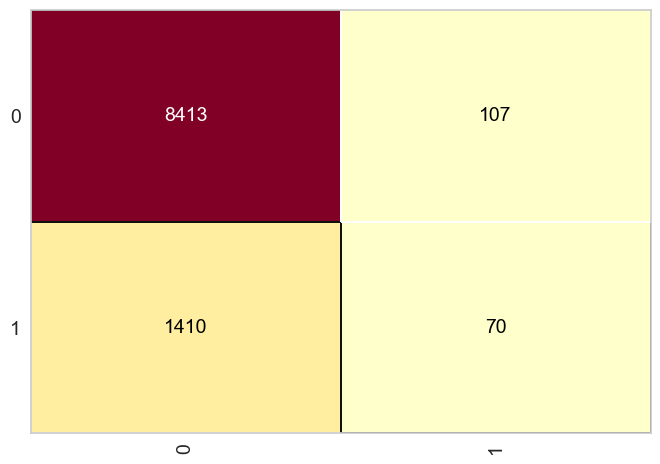

In [60]:
cm = ConfusionMatrix(clf_rf, classes=[0,1])
cm.fit(X_train, y_train)

cm.score(X_test, y_test)

Text(0.5, 0, 'Random Forest Feature Importance')

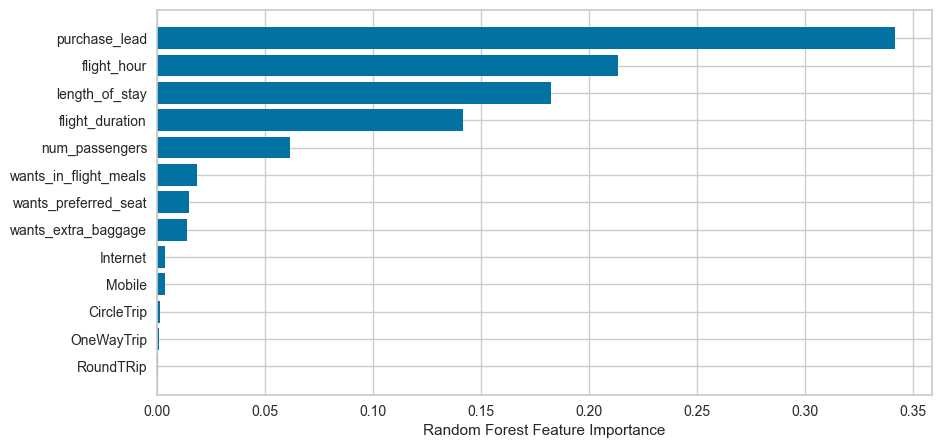

In [61]:
plt.figure(figsize=(10,5))
sorted_idx = clf_rf.feature_importances_.argsort()
plt.barh(scaled_df.iloc[:,:-1].columns[sorted_idx], clf_rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [62]:
# balancing the dataset
scaled_df.label.value_counts()

label
0    42522
1     7478
Name: count, dtype: int64

In [63]:
scaled_df_0 = scaled_df[scaled_df.label ==0].sample(n=8000)

In [64]:
scaled_df_new = pd.concat([scaled_df[scaled_df.label==1], scaled_df_0], ignore_index=True)

In [65]:
scaled_df_new = scaled_df_new.sample(frac = 1).reset_index(drop=True)

In [66]:
scaled_df_new

,num_passengers,purchase_lead,length_of_stay,flight_hour,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,Internet,Mobile,RoundTRip,OneWayTrip,CircleTrip,label
0,0.400684,3.350558,-0.502977,1.281021,-1.420965,-0.649919,-0.863497,-0.439297,0.355785,-0.355785,-0.048222,-0.08832,0.100808,0
1,-0.579559,-0.132011,0.588876,-0.381764,-1.420965,-0.649919,1.158082,1.037139,0.355785,-0.355785,-0.048222,-0.08832,0.100808,0
2,0.400684,0.265997,-0.532487,2.389544,0.703747,-0.649919,1.158082,-0.439297,0.355785,-0.355785,-0.048222,-0.08832,0.100808,0
3,0.400684,1.360518,-0.502977,1.096267,0.703747,-0.649919,1.158082,1.037139,0.355785,-0.355785,-0.048222,-0.08832,0.100808,0
4,-0.579559,1.758526,-0.532487,0.172497,-1.420965,-0.649919,1.158082,-0.185430,0.355785,-0.355785,-0.048222,-0.08832,0.100808,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15473,-0.579559,-0.331015,-0.119353,-0.012257,0.703747,-0.649919,-0.863497,-1.688589,0.355785,-0.355785,-0.048222,-0.08832,0.100808,1
15474,-0.579559,-0.916971,-0.532487,0.726759,-1.420965,-0.649919,-0.863497,-1.301108,0.355785,-0.355785,-0.048222,-0.08832,0.100808,1
15475,-0.579559,-0.717967,-0.532487,0.172497,0.703747,1.538654,-0.863497,-1.742035,0.355785,-0.355785,-0.048222,-0.08832,0.100808,1
15476,-0.579559,-0.397350,-0.502977,-1.305534,-1.420965,-0.649919,-0.863497,0.195370,0.355785,-0.355785,-0.048222,-0.08832,0.100808,0


In [67]:
X = scaled_df_new.iloc[:,:-1]
y = scaled_df_new['label']

X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.20, random_state=42)

In [68]:
# create an instance of the classifier and fit the training data
clf_rf = RandomForestClassifier(n_estimators=50,max_depth =50 , min_samples_split=5,random_state=0)

In [69]:
y_pred_test = model_fit_predict(clf_rf, X_train, y_train, X_test)

f1 = round(f1_score(y_test, y_pred_test),2) 

acc = round(accuracy_score(y_test, y_pred_test),2) 

pre = round(precision_score(y_test, y_pred_test),2) 

recall = round(recall_score(y_test, y_pred_test),2)

specificity = round(recall_score(y_test, y_pred_test, pos_label=0),2)

print(f"Accuracy, precision, recall and f1-score for training data are {acc}, {pre}, {recall}, {specificity} and {f1} respectively") 

Accuracy, precision, recall and f1-score for training data are 0.63, 0.61, 0.59, 0.66 and 0.6 respectively


0.6275839793281653

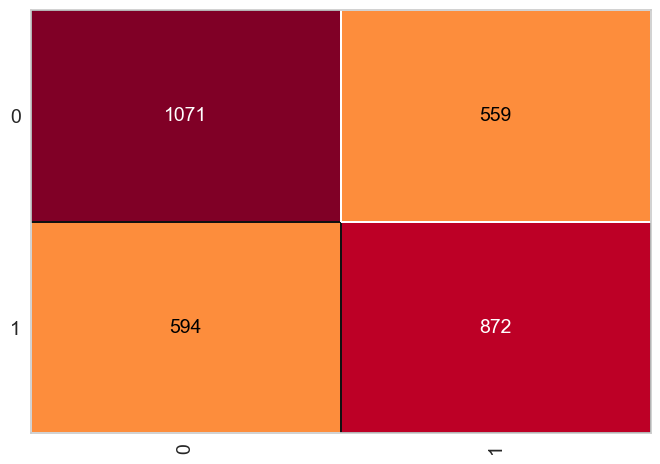

In [70]:
cm = ConfusionMatrix(clf_rf, classes=[0,1])
cm.fit(X_train, y_train)

cm.score(X_test, y_test)

Text(0.5, 0, 'Random Forest Feature Importance')

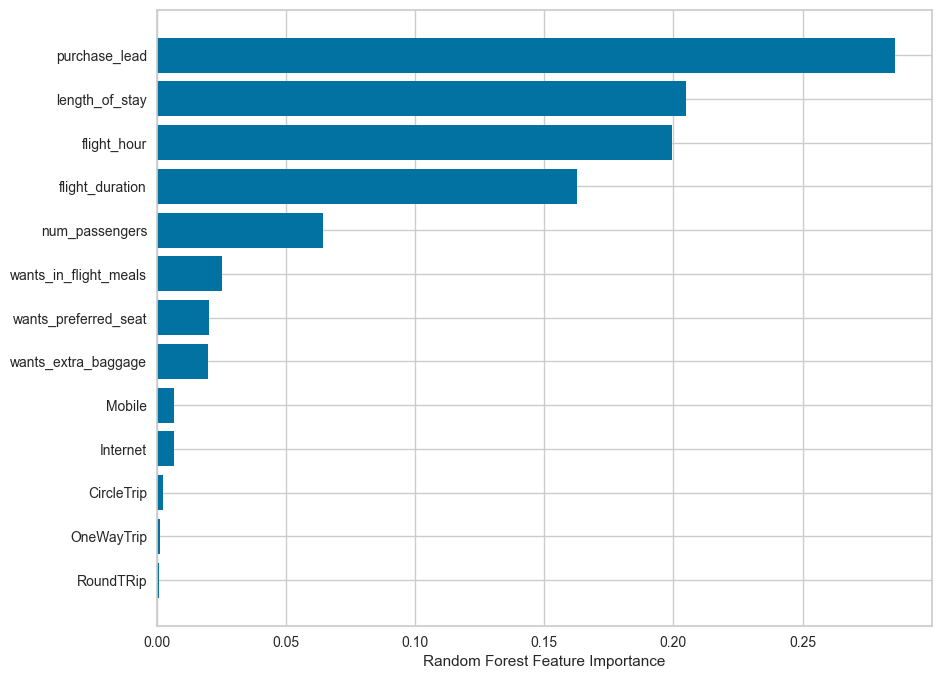

In [71]:
plt.figure(figsize=(10,8))
sorted_idx = clf_rf.feature_importances_.argsort()
plt.barh(scaled_df.iloc[:,:-1].columns[sorted_idx], clf_rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")